Group Beacon\
Project: SeaTurtleID2022\
Group Members:\
Haokai Zhao, Jonas Macken\
Liangji Kong, Ruiyuan Yang\
Yaqing He

In [1]:
import os
import json
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
metadata_path = "/kaggle/input/seaturtleid2022/turtles-data/data/metadata_splits.csv"
annotations_path = "/kaggle/input/seaturtleid2022/turtles-data/data/annotations.json"

metadata = pd.read_csv(metadata_path)
print("Metadata loaded successfully.")
print("Number of images in metadata:", len(metadata))
metadata.head()

with open(annotations_path, 'r') as file:
    annotations = json.load(file)
# Add background category
annotations['categories'].insert(0, {'id': 0, 'name': 'background', 'supercategory': ''})
print("Annotations loaded successfully.")
print("Keys in annotations:", annotations.keys())

Metadata loaded successfully.
Number of images in metadata: 8729
Annotations loaded successfully.
Keys in annotations: dict_keys(['licenses', 'info', 'categories', 'images', 'annotations'])


In [3]:
# Print some statistics about the dataset
num_images = len(annotations['images'])
num_annotations = len(annotations['annotations'])
num_categories = len(annotations['categories']) + 1

print(f"Total number of images: {num_images}")
print(f"Total number of annotations: {num_annotations}")
print(f"Number of categories: {num_categories}")

# Display a few image paths
print("First 3 image file names:")
for img in annotations['images'][:3]:
    print(img['file_name'])

# Display a sample annotation to understand the structure
print("\nFirst annotation example:")
for key, value in annotations['annotations'][0].items():
    print(f"{key}: {value}")
    
# Display categories to understand the structure
print("\ncategories:")
for value in annotations['categories']:
    print(f"{key}: {value}")

Total number of images: 8729
Total number of annotations: 38414
Number of categories: 5
First 3 image file names:
images/t001/CAluWEgwPX.JPG
images/t001/EKyrFKHQzh.JPG
images/t001/ELAvEqeXxT.JPG

First annotation example:
id: 1
image_id: 1
category_id: 3
segmentation: {'counts': [858927, 7, 1322, 23, 1306, 34, 1298, 36, 1296, 39, 1292, 42, 1291, 43, 1289, 45, 1287, 47, 1285, 48, 1285, 49, 1283, 51, 1281, 53, 1280, 54, 1278, 56, 1277, 56, 1277, 57, 1275, 58, 1274, 60, 1273, 61, 1272, 61, 1272, 62, 1270, 63, 1269, 64, 1268, 65, 1268, 65, 1268, 66, 1267, 67, 1266, 67, 1265, 68, 1264, 69, 1263, 70, 1263, 70, 1263, 70, 1263, 70, 1263, 70, 1263, 70, 1262, 71, 1261, 72, 1261, 72, 1261, 72, 1261, 72, 1261, 72, 1261, 72, 1261, 72, 1260, 73, 1260, 73, 1260, 73, 1259, 74, 1258, 75, 1258, 74, 1259, 73, 1260, 72, 1261, 71, 1262, 69, 1263, 69, 1264, 68, 1265, 66, 1266, 64, 1269, 63, 1269, 61, 1272, 59, 1274, 58, 1275, 55, 1278, 52, 1281, 15, 8, 25, 1285, 12, 16, 17, 1289, 9, 24, 3, 1297, 7, 1327, 4,

In [4]:
# Extract information about images and annotations
image_info = {img['id']: img for img in annotations['images']}

# Map image IDs to annotations
image_to_annotations = {}
for ann in annotations['annotations']:
    img_id = ann['image_id']
    if img_id not in image_to_annotations:
        image_to_annotations[img_id] = []
    image_to_annotations[img_id].append(ann)

# Use metadata to split dataset into train, val, and test sets
train_metadata = metadata[metadata['split_open'] == 'train']
val_metadata = metadata[metadata['split_open'] == 'valid']
test_metadata = metadata[metadata['split_open'] == 'test']

print("\nData split:")
print(f"Training set: {len(train_metadata)} images")
print(f"Validation set: {len(val_metadata)} images")
print(f"Test set: {len(test_metadata)} images")


Data split:
Training set: 5303 images
Validation set: 1118 images
Test set: 2308 images


In [5]:
pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 12.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageDraw
from pycocotools import mask as coco_mask

In [7]:
# Define a DeepLabV3 model with a ResNet backbone
model = models.segmentation.deeplabv3_resnet50(weights='DEFAULT')
model.classifier[4] = nn.Conv2d(256, num_categories, kernel_size=(1, 1))  # Adjust output channels to match the number of categories
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 183MB/s]  


In [8]:
class SeaTurtleDataset(Dataset):
    def __init__(self, metadata, annotations, image_info, transform=None, image_dir='/kaggle/input/seaturtleid2022/turtles-data/data'):
        self.metadata = metadata
        self.annotations = annotations
        self.image_info = image_info
        self.transform = transform
        self.image_dir = image_dir

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_id = self.metadata.iloc[idx]['id']
        img_data = self.image_info[img_id]
        img_path = os.path.join(self.image_dir, img_data['file_name'])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        # Generate target mask using segmentation information
        mask = np.zeros((img_data['height'], img_data['width']), dtype=np.uint8)  # Background initialized as 0
        
        for ann in self.annotations.get(img_id, []):
            if isinstance(ann['segmentation'], dict) and 'counts' in ann['segmentation']:
                # RLE to binary mask
                rle = coco_mask.frPyObjects(ann['segmentation'], img_data['height'], img_data['width'])
                binary_mask = coco_mask.decode(rle).astype(np.uint8)
                # print(f"Binary mask shape: {binary_mask.shape}, dtype: {binary_mask.dtype}, Unique values: {np.unique(binary_mask)}")
                # print(f"Binary mask for annotation ID {ann['id']}: {binary_mask}")
                # if np.any(binary_mask == 1):
                    # print(f"Assigning category ID {ann['category_id']} to mask.")
                # if np.all(binary_mask == 0):
                    # print(f"Warning: Binary mask for annotation ID {ann['id']} is empty.")
                # if len(binary_mask.shape) == 3:
                    # binary_mask = binary_mask[:, :, 0]  # Ensure binary_mask is 2D
                update_mask = (binary_mask == 1) & (mask != 2) & (mask != 3)
                mask[update_mask] = np.uint8(ann['category_id'])
                # one_count_mask = np.sum(mask != 0)
                # print(f"Number of not 0 in mask: {one_count_mask}")
                # print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}, Unique values: {np.unique(mask)}")
                # unique_values = np.unique(mask)
                # print(f"Unique values in mask after assignment: {unique_values}")
            else:
                print(f"Skipping unsupported segmentation format for annotation ID: {ann['id']}")

        # unique_values_after_mask_generation = np.unique(mask)
        # print(f"Unique values in mask after full generation: {unique_values_after_mask_generation}")
        # print(f"Complete mask for image ID {img_id}:{mask}")
        mask = Image.fromarray(mask)
        
        # Visualize mask for debugging purposes
        '''
        if np.random.rand() < 0.05:
            plt.figure(figsize=(6, 6))
            plt.imshow(mask, cmap='gray')
            plt.title(f"Mask for Image ID: {img_id}")
            plt.axis('off')
            plt.show()
        '''
        
        if self.transform:
            mask = mask.resize((256, 256), resample=Image.NEAREST)
            mask = transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.long))(mask)
        else:
            mask = transforms.ToTensor()(mask)

        return image, mask

In [9]:
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

In [10]:
train_dataset = SeaTurtleDataset(train_metadata, image_to_annotations, image_info, transform=transform)
val_dataset = SeaTurtleDataset(val_metadata, image_to_annotations, image_info, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU Model: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU Model: Tesla P100-PCIE-16GB


In [12]:
epochs = 12
loss_history = []
print("Training started...")
for epoch in range(epochs):
    model.train()
    print(f"Epoch {epoch+1}/{epochs} started...")
    running_loss = 0.0
    for batch_idx, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)
        if batch_idx % (len(train_loader) // 10) == 0:
            print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Processing {batch_idx / len(train_loader) *100:.1f}%, Current Loss: {running_loss / (batch_idx + 1):.4f}")

        # Forward pass
        outputs = model(images)['out']
        loss = criterion(outputs, masks.squeeze(1).long())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    loss_history.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Training started...
Epoch 1/12 started...
Epoch 1/12, Batch 0/663, Processing 0.0%, Current Loss: 0.0000
Epoch 1/12, Batch 66/663, Processing 10.0%, Current Loss: 0.4214
Epoch 1/12, Batch 132/663, Processing 19.9%, Current Loss: 0.3097
Epoch 1/12, Batch 198/663, Processing 29.9%, Current Loss: 0.2659
Epoch 1/12, Batch 264/663, Processing 39.8%, Current Loss: 0.2340
Epoch 1/12, Batch 330/663, Processing 49.8%, Current Loss: 0.2147
Epoch 1/12, Batch 396/663, Processing 59.7%, Current Loss: 0.1969
Epoch 1/12, Batch 462/663, Processing 69.7%, Current Loss: 0.1833
Epoch 1/12, Batch 528/663, Processing 79.6%, Current Loss: 0.1765
Epoch 1/12, Batch 594/663, Processing 89.6%, Current Loss: 0.1672
Epoch 1/12, Batch 660/663, Processing 99.5%, Current Loss: 0.1609
Epoch [1/12], Loss: 0.1609
Epoch 2/12 started...
Epoch 2/12, Batch 0/663, Processing 0.0%, Current Loss: 0.0000
Epoch 2/12, Batch 66/663, Processing 10.0%, Current Loss: 0.0785
Epoch 2/12, Batch 132/663, Processing 19.9%, Current Loss: 

In [13]:
torch.save(model.state_dict(), '/kaggle/working/deeplabv3_seaturtle.pth')
print("Model training complete and saved as 'deeplabv3_seaturtle.pth'")

Model training complete and saved as 'deeplabv3_seaturtle.pth'


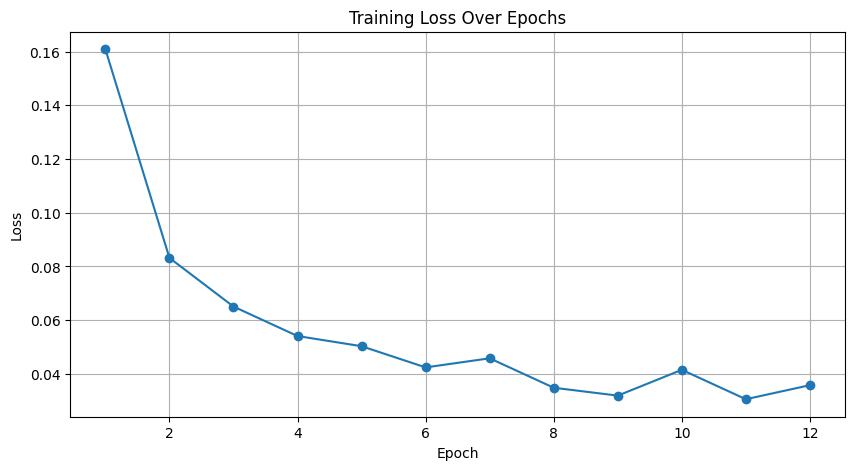

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

In [15]:
from torchvision.ops import box_iou
from sklearn.metrics import precision_recall_curve, auc

In [16]:
def calculate_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask)
    union = np.logical_or(pred_mask, true_mask)
    if np.sum(union) == 0:
        return float('nan')  # Avoid division by zero
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_average_precision(preds, labels):
    precision, recall, _ = precision_recall_curve(labels, preds)
    return auc(recall, precision)

In [21]:
test_dataset = SeaTurtleDataset(test_metadata, image_to_annotations, image_info, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

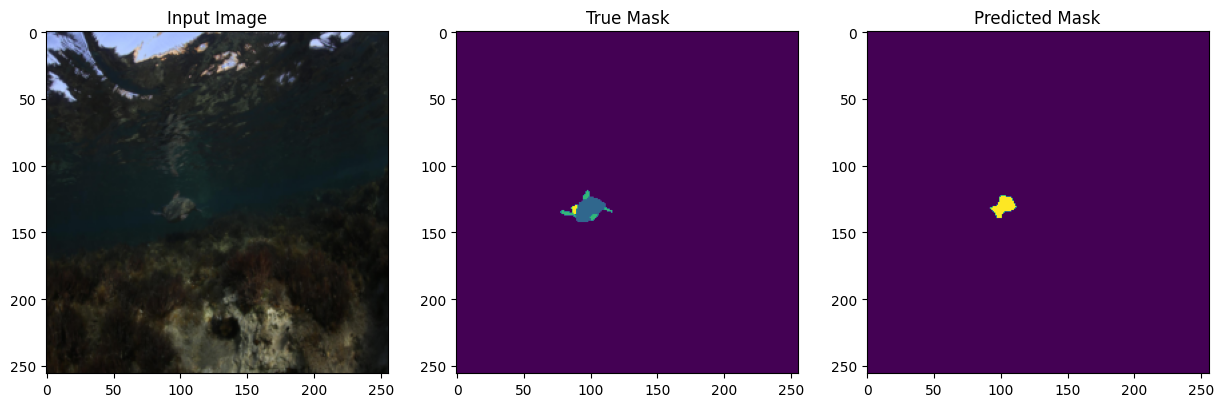

Successful segmentation for category: turtle, IoU: 0.5488
Mean Average Precision (mAP) for category: turtle, AP: 0.8975
Failed segmentation for category: flippers, IoU: 0.0000
Mean Average Precision (mAP) for category: flippers, AP: 0.1003
Failed segmentation for category: head, IoU: 0.0000
Mean Average Precision (mAP) for category: head, AP: 0.0182


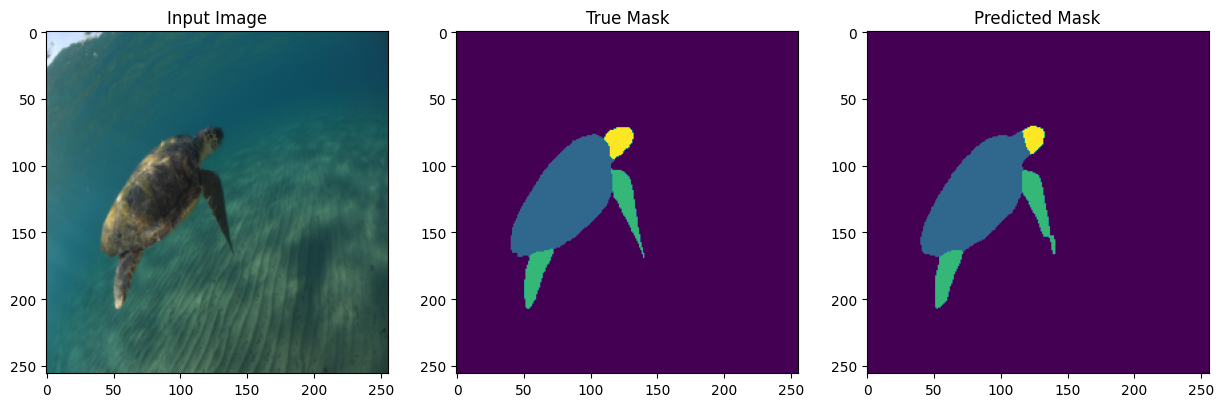

Successful segmentation for category: turtle, IoU: 0.9468
Mean Average Precision (mAP) for category: turtle, AP: 0.9946
Successful segmentation for category: flippers, IoU: 0.8807
Mean Average Precision (mAP) for category: flippers, AP: 0.9871
Successful segmentation for category: head, IoU: 0.6474
Mean Average Precision (mAP) for category: head, AP: 0.9513


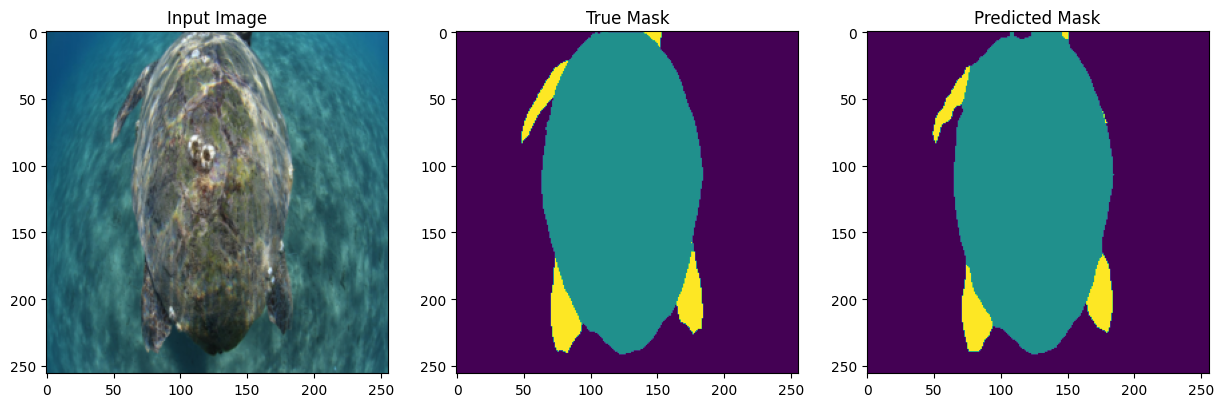

Successful segmentation for category: turtle, IoU: 0.9791
Mean Average Precision (mAP) for category: turtle, AP: 0.9997
Successful segmentation for category: flippers, IoU: 0.8225
Mean Average Precision (mAP) for category: flippers, AP: 0.9730


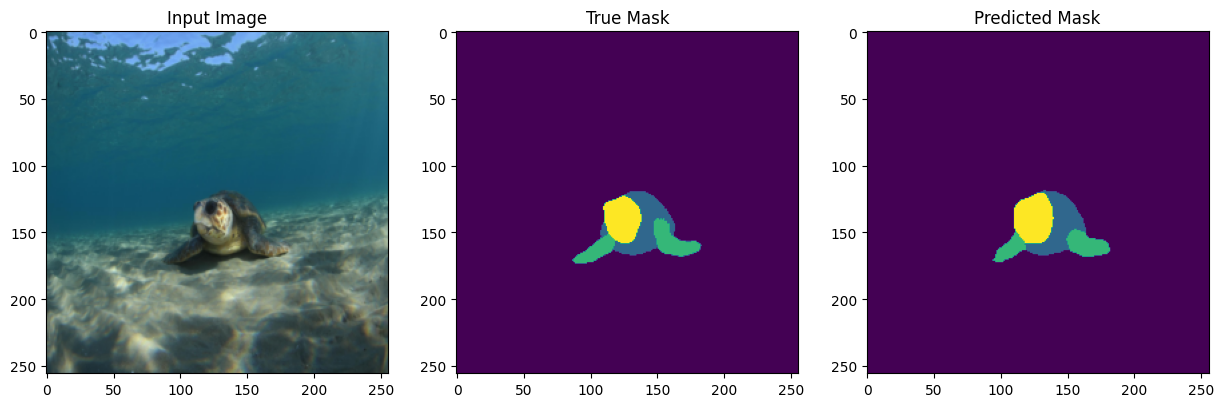

Successful segmentation for category: turtle, IoU: 0.7284
Mean Average Precision (mAP) for category: turtle, AP: 0.8870
Successful segmentation for category: flippers, IoU: 0.7149
Mean Average Precision (mAP) for category: flippers, AP: 0.9309
Successful segmentation for category: head, IoU: 0.8505
Mean Average Precision (mAP) for category: head, AP: 0.9927


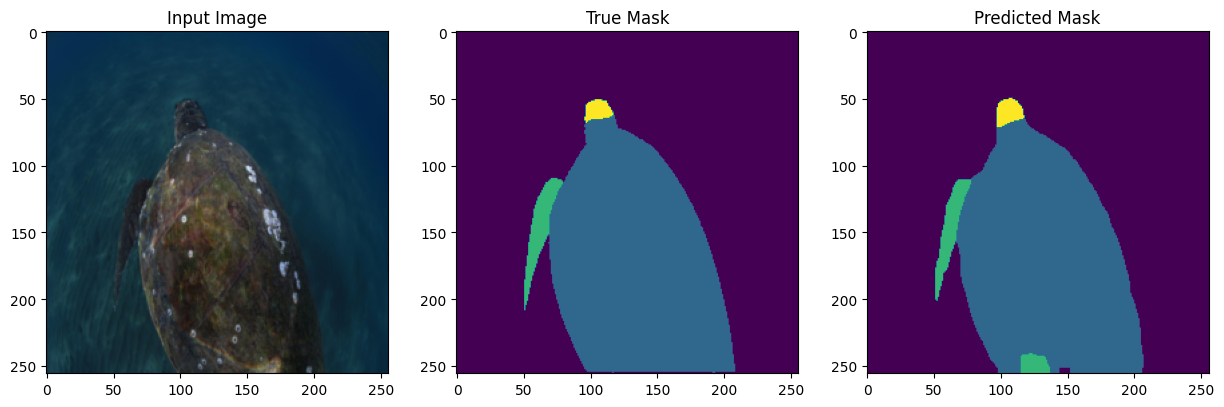

Successful segmentation for category: turtle, IoU: 0.9624
Mean Average Precision (mAP) for category: turtle, AP: 0.9992
Successful segmentation for category: flippers, IoU: 0.6497
Mean Average Precision (mAP) for category: flippers, AP: 0.9124
Successful segmentation for category: head, IoU: 0.7619
Mean Average Precision (mAP) for category: head, AP: 0.9763


In [22]:
model.eval()
iou_scores = {'turtle': [], 'flippers': [], 'head': []}
mAP_scores = {'turtle': [], 'flippers': [], 'head': []}

example_num = 0
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)['out']
        preds = torch.softmax(outputs, dim=1).cpu().numpy()  # Use softmax probabilities
        masks = masks.squeeze(1).cpu().numpy()
        
        if example_num < 5:
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(images[0].cpu().permute(1, 2, 0))
            axes[0].set_title("Input Image")
            axes[1].imshow(masks[0])
            axes[1].set_title("True Mask")
            axes[2].imshow(np.argmax(preds[0], axis=0))
            axes[2].set_title("Predicted Mask")
            plt.show()

        for i in range(len(preds)):
            pred_probs = preds[i]
            true_mask = masks[i]

            for category_id, category_name in zip([1, 2, 3], ['turtle', 'flippers', 'head']):
                true_category_mask = (true_mask == category_id).flatten()
                pred_category_probs = pred_probs[category_id].flatten()
                pred_category_mask = (np.argmax(preds[0], axis=0) == category_id)

                if np.sum(true_category_mask) > 0:  # Avoid division by zero
                    # Calculate IoU
                    pred_category_mask = (np.argmax(pred_probs, axis=0) == category_id)
                    iou = calculate_iou(pred_category_mask, true_mask == category_id)
                    iou_scores[category_name].append(iou)
                    # Calculate mAP
                    ap = calculate_average_precision(pred_category_probs, true_category_mask)
                    mAP_scores[category_name].append(ap)
                    if example_num < 5:
                        if iou < 0.5:
                            print(f"Failed segmentation for category: {category_name}, IoU: {iou:.4f}")
                        else:
                            print(f"Successful segmentation for category: {category_name}, IoU: {iou:.4f}")
                        print(f"Mean Average Precision (mAP) for category: {category_name}, AP: {ap:.4f}")
        example_num += 1

In [23]:
# Calculate mean IoU for each category
mean_iou_scores = {category: np.mean(scores) for category, scores in iou_scores.items()}
print("\nMean IoU scores:")
for category, mean_iou in mean_iou_scores.items():
    print(f"{category}: {mean_iou:.4f}")

# Calculate mean AP for each category
mean_mAP_scores = {category: np.mean(scores) for category, scores in mAP_scores.items()}
print("\nMean COCO mAP scores:")
for category, mean_ap in mean_mAP_scores.items():
    print(f"{category}: {mean_ap:.4f}")


Mean IoU scores:
turtle: 0.8550
flippers: 0.6739
head: 0.7039

Mean COCO mAP scores:
turtle: 0.9656
flippers: 0.8530
head: 0.8893
